# Derivation

Discretely many importance weights and rewards, maximum likelihood of sample $\{ (w_i, r_i) \}$ from $h$ is $$
\begin{alignat}{2}
&\!\max_{Q \succeq 0} &\qquad& \sum_n \log(Q_{w_n, r_n}),\label{eq:mle}\\
&\text{subject to} &  & \vec{w}^\top Q \vec{1} = 1, \tag{$\beta$} \label{eq:mlesumw} \\
&                  &  & \vec{1}^\top Q \vec{1} = 1. \tag{$\gamma$} \label{eq:mlesum}
\end{alignat}
$$
Estimate is $\hat V(\pi) = \vec{w}^\top \hat{Q} \vec{r}$. 

Dual (ignoring constants) is $$
\begin{aligned}
\sup_{\beta,\gamma}& -\beta - \gamma + \sum_{n} \log\left(w_n \beta + \gamma\right)\; \text{ s.t. } \; \forall w,r: w \beta + \gamma \geq 0.
\end{aligned}
$$ One dual variable can be eliminated by summing the KKT stationarity conditions and leveraging complementary slackness.  Introducing $\phi \succeq 0$ as the (matrix of) dual variables associated with $Q \succeq 0$: $$
\begin{aligned}
\frac{c_{w_i,r_j}}{q_{w_i,r_j}} &= \phi_{w_i,r_j} + w_i \beta + \gamma \implies n = 0 + \beta + \gamma, \\
\end{aligned}
$$ resulting in the 1-D dual $$
\begin{aligned}
\sup_{\beta} & \sum_{n} \log\left((w_n - 1) \beta + n\right) \; \text{ s.t. } \;\forall w,r: (w - 1) \beta + n \geq 0.
\end{aligned}
$$  This can be solved by 1-D bracketed search on the gradient followed by recovery of the primal values.

Primary recovery begins with the primal-dual relationship for observed $(w, r)$ pairs: $$
\hat Q_{w,r} = \sum_n \frac{\mathbb{1}_{w=w_n,r=r_n}}{\beta^* (w_n - 1) + N}.
$$  The MLE will sometimes put mass on unobserved importance weights, in which case the distribution over rewards for that importance weight is not determined.  The unobserved mass can be determined by solving the linear feasibility problem $$
\begin{alignat}{2}
& &  & w_{\min} \hat{q}_{\min} + w_{\max} \hat{q}_{\max} = 1 - \sum_n \frac{w_n}{\beta^* (w_n - 1) + N}, \notag \\
&                  &  & \hat{q}_{\min} + \hat{q}_{\max} = 1 - \sum_n \frac{1}{\beta^* (w_n - 1) + N}, \notag \\
& & & {\hat{q}_{\min} \geq 0, \hat{q}_{\max} \geq 0},\notag
\end{alignat}
$$
where $\hat{q}_{\min}$ and $\hat{q}_{\max}$ are associated with
$w_{\min}$ and $w_{\max}$ respectively.  For robustness we convert this into a non-negative least squares problem $$
\begin{alignat}{2}
&\!\min_{q_{\min} \geq 0, q_{\max} \geq 0} &\qquad& \left\| \left(\begin{array}{cc} 1 & 1 \\ w_{\min} & w_{\max} \end{array} \right) \left(\begin{array}{c} q_{\min} \\ q_{\max} \end{array}\right) - \left(\begin{array}{c} 1 - \sum_n \frac{1}{\beta^* (w_n - 1) + N} \\ 1 - \sum_n \frac{w_n}{\beta^* (w_n - 1) + N} \end{array} \right) \right\|^2. \notag
\end{alignat}
$$
When $q_{\min} + q_{\max} > 0$, the MLE is actually an interval; the center of this interval is found using $1/2 (r_{\min} + r_{\max})$ as the reward for unobserved importance weights.

**Using a baseline:** When using a baseline, pass in shifted rewards and then add the correction to the result.  Given reward predictor $\hat r: \mathcal{X} \times A \to [r_{\min}, r_{\max}]$, construct data for the MLE $$
\begin{aligned}
(w_n, \tilde r_n) &\leftarrow \left(\frac{\pi(a_n|x_n)}{h(a_n|x_n)}, r_n - \hat
r(x_n, a_n) \right),
\end{aligned}
$$ apply the MLE on this data (with modified $\tilde r_{\min}$ and $\tilde r_{\max}$), and then adjust the result via $$
\begin{aligned}
\hat V^{\text{(rpmle)}} &= \hat V^{\text{(mle)}} + \sum_n \sum_a \pi(a_n|x_n) \hat r(x_n, a_n).
\end{aligned}
$$

**With censorship**: Suppose some $r_j = \varnothing$ implying the reward was exogenously censored, and suppose we want to estimate $$
\begin{aligned}
\mathbb{E}\left[r | r \neq \varnothing\right] = \frac{\mathbb{E}\left[r 1_{r \neq \varnothing}\right]}{\mathbb{E}\left[1_{r \neq \varnothing}\right]}.
\end{aligned}
$$ One possible estimate is $$
\begin{aligned}
\hat V(\pi) = \frac{w^\top Q (r 1_{r \neq \varnothing})}{w^\top Q 1_{r \neq \varnothing}}
\end{aligned}
$$ which is straightforward when there is no mass assigned to unobserved importance weights.  When there is mass assigned to unobserved importance weights, the MLE is again an interval and we can choose the center point of the interval as the estimate.

In python we represent censored rewards with `None`.

## Limiting Behaviour

If $w_{\max} \to \infty$ but $\sum_n w_n < 1$, then $$
\begin{aligned}
\left. \frac{\partial}{\partial \beta} \left( \sum_{n} \log\left((w_n - 1) \beta + N\right) \right) \right|_{\beta=0} &= \sum_n \frac{w_n - 1}{N} < 0,
\end{aligned}
$$ therefore $\beta^* < 0$, but $\beta^* (w_{\max} - 1) +n \geq 0$ therefore $\beta^* \uparrow 0$.  Thus $$
\begin{aligned}
\hat V(\pi) &\to \frac{1}{N} \sum_n w_n r_n + \left(1 - \frac{1}{N} \sum_n w_n\right) \rho
\end{aligned}
$$ where $\rho \in [ r_{\min}, r_{\max} ]$.

If $w_{\min} = 0$ but $\sum_n w_n > 1$, then additional mass does not affect the value estimate which is therefore a point estimate.

## Deviations

$$
\begin{aligned}
\hat V(\pi) &= \rho + \frac{1}{N} \sum_n \frac{w_n (r_n - \rho)}{1 + \beta^* (w_n - 1)}, \\
\beta^* &= \arg \sup_{\beta} \left. \left\{ \sum_n \log\left(1 + \beta (w_n - 1) \right) \right| \forall w: 1 + \beta (w - 1) \geq 0 \right\}.
\end{aligned}
$$

### Lemma 1

$$
\begin{aligned}
\left| \beta^* \right| \sum_n \frac{(w_n - 1)^2}{1 + \beta^* (w_n - 1)} &\leq \left| \sum_n (w_n - 1) \right|
\end{aligned}
$$ with equality for the unconstrained maximizer.

#### Proof

For the unconstrained maximizer, $$
\begin{aligned}
0 &= \sum_n \frac{w_n - 1}{1 + \beta^* (w_n - 1)} \\
&= \sum_n (w_n - 1) \left( 1 - \frac{\beta^* (w_n - 1)}{1 + \beta^* (w_n - 1)} \right), \\
\beta^* \sum_n \frac{(w_n - 1)^2}{1 + \beta^* (w_n - 1)} &= \sum_n (w_n - 1), \\
\left| \beta^* \right| \sum_n \frac{(w_n - 1)^2}{1 + \beta^* (w_n - 1)} &= \left| \sum_n (w_n - 1) \right|.
\end{aligned}
$$ For the constrained maximizer, first note the sign of $\beta^*$ is the sign of $\sum_n (w_n - 1)$, $$
\begin{aligned}
\left. \sum_n \frac{w_n - 1}{1 + \beta (w_n - 1)} \right|_{\beta=0} &= \sum_n (w_n - 1).
\end{aligned}
$$
If the constrained maximizer is positive than $$
\begin{aligned}
0 &< \left. \frac{\partial}{\partial \beta} \sum_n \log\left(1 + \beta (w_n - 1)\right)\right|_{\beta=\beta^*} \\
&= \sum_n \frac{w_n - 1}{1 + \beta^* (w_n - 1) } \\
&= \sum_n (w_n - 1) \left( 1 - \frac{\beta^* (w_n - 1)}{1 + \beta^* (w_n - 1)} \right), \\
\beta^* \sum_n \frac{(w_n - 1)^2}{1 + \beta^* (w_n - 1)} &< \sum_n (w_n - 1), \\
\left| \beta^* \right| \sum_n \frac{(w_n - 1)^2}{1 + \beta^* (w_n - 1)} &< \left| \sum_n (w_n - 1) \right|.
\end{aligned}
$$ If the constrained maximizer is negative than $$
\begin{aligned}
0 &> \left. \frac{\partial}{\partial \beta} \sum_n \log\left(1 + \beta (w_n - 1)\right)\right|_{\beta=\beta^*} \\
&= \sum_n \frac{w_n - 1}{1 + \beta^* (w_n - 1)} \\
&= \sum_n (w_n - 1) \left( 1 - \frac{\beta^* (w_n - 1)}{1 + \beta^* (w_n - 1)} \right), \\
\beta^* \sum_n \frac{(w_n - 1)^2}{1 + \beta^* (w_n - 1)} &> \sum_n (w_n - 1), \\
\left| \beta^* \right| \sum_n \frac{(w_n - 1)^2}{1 + \beta^* (w_n - 1)} &< \left| \sum_n (w_n - 1) \right|.
\end{aligned}
$$.

### Lemma 2 (Freedman)

For an arbitrary sequence of logging policies, $$
\begin{aligned}
\mathbb{E}\left[\frac{1}{N} \left| \sum_n (w_n - 1) \right|\right] &\leq 5 \sqrt{\frac{w_{\max}}{N}} + 4 e^{-\frac{4}{3} \frac{w_{\max}}{N}} \frac{w_{\max}}{N}.
\end{aligned}
$$

#### Proof

$\sum_n (w_n - 1)$ is a martingale with bounded predictable quadratic variation $\mathbb{E}_{n-1}[(w_n - 1)^2] \leq w_{\max}$.  Hence Freedman's inequality applies.

### Bias Finite Sample Result

Consider estimator of the value difference with logging policy $$
\begin{aligned}
\hat{R}(\pi) &= \hat{V}(\pi) - \hat{V}(h) = \rho + \frac{1}{N} \sum_n \frac{w_n}{1 + \beta^* (w_n - 1)} (r_n - \rho) - \left(\rho + \sum_n \frac{1}{1 + \beta^* (w_n - 1)} (r_n - \rho)\right) \\
&= \sum_n \frac{(w_n - 1)}{1 + \beta^* (w_n - 1)} (r_n - \rho).
\end{aligned}
$$ We can determine the bias of $\hat{R}(\pi)$ by taking differences with the doubly-robust estimator which is unbiased. $$
\begin{aligned}
\Delta &= \frac{1}{N} \sum_n \frac{(w_n - 1)}{1 + \beta^* (w_n - 1)} (r_n - \rho) - \frac{1}{N} \sum_n (w_n - 1) (r_n - \rho) \\
&= \frac{1}{N} \sum_n (w_n - 1) (r_n - \rho)  \left(1 - \frac{1}{1 + \beta^* (w_n - 1)}\right) \\
&= \frac{1}{N} \sum_n (r_n - \rho) \frac{\beta^* (w_n - 1)^2}{1 + \beta^* (w_n - 1)}, \\
|\Delta| &\leq |r_n - \rho|_{\infty} \frac{1}{N} |\beta^*| \sum_n \frac{(w_n - 1)^2}{1 + \beta^* (w_n - 1)} \\
&\leq |r_n - \rho|_{\infty} \frac{1}{N} \left| \sum_n (w_n - 1) \right|. \\
\text{Bias} &= \mathbb{E}\left[ \Delta \right] \leq \mathbb{E}\left[ \left| \Delta \right| \right] \\
&\leq |r_n - \rho|_{\infty} \mathbb{E}\left[ \frac{1}{N} \left| \sum_n (w_n - 1) \right| \right] \\
&\leq |r_n - \rho|_{\infty} \left( 5 \sqrt{\frac{w_{\max}}{N}} + 4 e^{-\frac{4}{3} \frac{w_{\max}}{N}} \frac{w_{\max}}{N} \right).
\end{aligned}
$$

# Tests

## Censorship changes results

We learned this the hard way.

In [1]:
data, wmin, wmax, censored = None, None, None, None
for data, wmin, wmax, censored in [
    # some data where exogenous censorship is discarded
   ([ (c, w, r) for c, w, r in [ 
      (86, -59.999996, 0.0), (44884, -1.0497237, 0.0), (16331, -1.0447762, 0.0), (31257, -1.0344828, 0.0), 
      (15868, -1.0, 0.0), (41332, 0.0, 0.0), (1958, 0.0, 1.0), (17763, 1.0, 0.0), (1339, 1.0, 1.0), 
      (30726, 1.0344828, 0.0), (3867, 1.0344828, 1.0), (2034, 1.0447762, 1.0), (16728, 1.0447762, 0.0), 
      (40629, 1.0497237, 0.0), (3445, 1.0497237, 1.0), (85, 59.999996, 0.0), (6, 59.999996, 1.0), 
     ]
     if w >= 0
    ], 0, 380, False),
    # same data where exogenous censorship is modeled
   ([ (c, -w if w < 0 else w, None if w < 0 else r) for c, w, r in [ 
      (86, -59.999996, 0.0), (44884, -1.0497237, 0.0), (16331, -1.0447762, 0.0), (31257, -1.0344828, 0.0), 
      (15868, -1.0, 0.0), (41332, 0.0, 0.0), (1958, 0.0, 1.0), (17763, 1.0, 0.0), (1339, 1.0, 1.0), 
      (30726, 1.0344828, 0.0), (3867, 1.0344828, 1.0), (2034, 1.0447762, 1.0), (16728, 1.0447762, 0.0), 
      (40629, 1.0497237, 0.0), (3445, 1.0497237, 1.0), (85, 59.999996, 0.0), (6, 59.999996, 1.0), 
     ]], 0, 380, True),
]:
    import MLE.MLE

    from pprint import pformat
    print(pformat(MLE.MLE.estimate(datagen=lambda: data, 
                                   wmin=wmin, wmax=wmax, rmin=0, rmax=1, raiseonerr=True, censored=censored)))
  
del data, wmin, wmax, censored

(0.17414127154917453,
 {'betastar': -421.93139841688657,
  'num': 159912,
  'qfunc': <function estimate.<locals>.<lambda> at 0x7fab4ab73e18>,
  'vmax': 0.276316821372124,
  'vmin': 0.07196572172622505})
(0.1522250873888096,
 {'betastar': -708.0158311345647,
  'num': 268338,
  'qfunc': <function estimate.<locals>.<lambda> at 0x7fab4ab73ea0>,
  'vmax': 0.2276442757816804,
  'vmin': 0.07680589899593883})


## Comparison with CVX

In [1]:
# CVXPY (primal) implementation

class MLETest:
    @staticmethod
    def cvxestimate(data, wmin, wmax, rmin, rmax):
        import cvxpy as cp
        import numpy as np
        from collections import defaultdict
        
        cdict = defaultdict(int)
        n = 0
        for (ci, wi, ri) in data:
            assert ci >= 0
            assert wi >= wmin and wi <= wmax
            assert ri >= rmin and ri <= rmax
            if ci > 0:
                cdict[(wi, ri)] += ci
            n += ci
        assert n >= 1
        cdict[(wmin, rmin)] += 0
        cdict[(wmin, rmax)] += 0
        cdict[(wmax, rmin)] += 0
        cdict[(wmax, rmax)] += 0
        cdict.default_factory = None
        
        wvec = np.array(list(set(w for (w, _), _ in cdict.items())))
        wmaxvec = np.max(wvec)
        rvec = np.array(list(set(r for (_, r), _ in cdict.items())))
        C = np.array([ [ cdict.get((w, r), 0)/n for r in rvec ] for w in wvec ])
        Q = cp.Variable((len(wvec), len(rvec)))
            
        prob = cp.Problem(cp.Maximize(cp.sum(cp.multiply(C, cp.log(Q)))), [
                                cp.sum(cp.matmul((wvec/wmaxvec).T, Q)) == 1/wmaxvec,
                                cp.sum(Q) == 1
                          ])
        prob.solve(solver='ECOS')
            
        vhat = 0
        for i, wi in enumerate(wvec):
            for j, rj in enumerate(rvec):
                if cdict.get((wi, rj), 0) > 0:
                    vhat += wi * Q.value[i, j] * rj
                else:
                    vhat += wi * Q.value[i, j] * 0.5 * (rmax - rmin)
 
        from scipy.special import xlogy
    
        return vhat, { 
            'qstar': { (wvec[i], rvec[j]): Q.value[i, j] for i in range(len(wvec)) for j in range(len(rvec)) },
            'likelihood': np.sum(xlogy(C, Q.value)),
            'sumofone': np.sum(Q.value),
            'sumofw': np.sum(wvec.dot(Q.value)),
        }

In [2]:
def testestimate():
    from importlib import reload
    from math import ceil
    import environments.ControlledRangeVariance
    import MLE.MLE
    import numpy as np
    from tqdm import tqdm as tqdm
    import sys

    reload(environments.ControlledRangeVariance)
    reload(MLE.MLE)

    wsupport = [ 0, 2, 20 ]
    wmax = wsupport[-1]
    env = environments.ControlledRangeVariance.ControlledRangeVariance(seed=45, wsupport=wsupport, expwsq=5)

    for ndata in tqdm(map(ceil, np.logspace(1, 7, 14)), file=sys.stderr, total=14):
        for i in range(1001):
            (truevalue, data) = env.sample(ndata)
            vhat, qstar = MLE.MLE.estimate(datagen = lambda: data, wmin=0, wmax=wmax, rmin=0, rmax=1, raiseonerr=True)
            cvxvhat, cvxqstar = MLETest.cvxestimate(data, wmin=0, wmax=wmax, rmin=0, rmax=1)
 
            from pprint import pformat
            assert np.allclose(vhat, cvxvhat, atol=1e-4), pformat(
            {
                'data': [(c, w, r) for c, w, r in data if c > 0],
                'vhat': vhat,
                'cvxvhat': cvxvhat,
                'qstar': qstar,
                'cvxqstar': cvxqstar,
            })
                                    
testestimate()

100%|██████████| 14/14 [01:27<00:00,  6.22s/it]


In [3]:
def megatestestimate():
    from importlib import reload
    from math import ceil
    import environments.ControlledRangeVariance
    import MLE.MLE
    import numpy as np
    from tqdm import tqdm as tqdm
    import sys

    reload(environments.ControlledRangeVariance)
    reload(MLE.MLE)
    
    def getenv():
        import numpy
        wsupport = numpy.geomspace(0.5, 1000, 10)
        env = environments.ControlledRangeVariance.ControlledRangeVariance(seed=45, wsupport=wsupport, expwsq=100)
        return env, env.getpw(), env.range(), env.expectedwsq()

    env = getenv()[0]
    wmin, wmax = env.range()
    
    for ndata in tqdm(map(ceil, np.logspace(1, 7, 14)), file=sys.stderr, total=14):
        for i in range(1001):
            (truevalue, data) = env.sample(ndata)
            vhat, qstar = MLE.MLE.estimate(lambda: data, wmin=wmin, wmax=wmax, rmin=0, rmax=1, raiseonerr=True)
            try:
                cvxvhat, cvxqstar = MLETest.cvxestimate(data, wmin=wmin, wmax=wmax, rmin=0, rmax=1)
            except:
                continue
                
            from pprint import pformat
            assert np.allclose(vhat, cvxvhat, atol=1e-4) or not np.isfinite(cvxqstar['likelihood']), pformat(
            {
                'data': [(c, w, r) for c, w, r in data if c > 0],
                'vhat': vhat,
                'cvxvhat': cvxvhat,
                'qstar': qstar,
                'cvxqstar': cvxqstar,
            })
                                    
megatestestimate()

100%|██████████| 14/14 [01:36<00:00,  6.86s/it]


# Comparison with baselines

In [4]:
def produceresults(env, method, maxexp=5, numpts=20, ndataperpt=10000):
    from math import ceil
    import numpy as np
    
    wmin, wmax = env.range()

    for ndata in map(ceil, np.logspace(1, maxexp, numpts)):
        estimates=[]
        for i in range(1, ndataperpt+1):
            (truevalue, data) = env.sample(ndata)
            try:
                estimate = None
                estimate = method(data=data, wmin=wmin, wmax=wmax)
                assert np.isfinite(estimate)
            except:
                print('truevalue was {}'.format(truevalue))
                print('data was {}'.format(data))
                print('estimate was {}'.format(estimate))
                raise
            
            essden = sum(c*w*w for (c, w, _) in data)
            essnum = sum(c*w for (c, w, _) in data)
            ess = 0 if essden == 0 else essnum*(essnum/essden)
                                                
            estimates.append(
                ( truevalue,
                  truevalue - estimate,
                  (truevalue - estimate)**2,
                 ess
                )  
            )
            
        yield (ndata,
                { 
                    'bias': np.abs(np.mean([ x[1] for x in estimates])),
                    'biasstd': np.std([ x[1] for x in estimates ], ddof=1) / np.sqrt(len(estimates) - 1),
                    'mse': np.mean([ x[2] for x in estimates ]),
                    'msestd': np.std( [ x[2] for x in estimates ], ddof=1) / np.sqrt(len(estimates) - 1),
                    'ess': np.mean([ x[3] for x in estimates ]),
                    'essstd': np.std([ x[3] for x in estimates ], ddof=1) / np.sqrt(len(estimates) - 1),
                },
              )
        
class ClippedDR:
    @staticmethod
    def estimate(data, baseline=0.5, **kwargs):
        import numpy as np
        n = sum(c for c, _, _ in data)
        return baseline if n == 0 else np.clip(sum(c*w*(r-baseline)+c*baseline for c, w, r in data) / n, a_min=0, a_max=1)
    
class SNIPS:
    @staticmethod
    def estimate(data, **kwargs):
        effn = sum(c*w for c, w, _ in data)
        return 0.5 if effn == 0 else sum(c*w*r for c, w, r in data) / effn

from importlib import reload
import environments.ControlledRangeVariance
import MLE.MLE

reload(environments.ControlledRangeVariance)
reload(MLE.MLE)

def getenv():
    wsupport = [ 0, 2, 1000 ]
    env = environments.ControlledRangeVariance.ControlledRangeVariance(seed=45, wsupport=wsupport, expwsq=100)
    return env, env.getpw(), env.range(), env.expectedwsq()

allres = []
for (name, method) in [ ('Constant 0.5', lambda **kwargs: 0.5),
                        ('ClippedDR', ClippedDR.estimate),
                        ('SNIPS', SNIPS.estimate),
                        ('MLE', lambda data, **kwargs: MLE.MLE.estimate(datagen=lambda: data, **kwargs)[0]),
                      ]:
    print('****** {} ******'.format(name))
    res = []
    for zzz in produceresults(getenv()[0], method, numpts=14):
        res.append(zzz)
#         print('{}'.format(zzz), flush=True)
    wmax = getenv()[2][1]
    allres.append((name, [(x[0] / wmax, x[1]) for x in res]))
    del wmax
import pickle
pickle.dump( allres, open( "epsilongreedy_estimate_allres.p", "wb" ) )

****** Constant 0.5 ******
****** ClippedDR ******
****** SNIPS ******
****** MLE ******


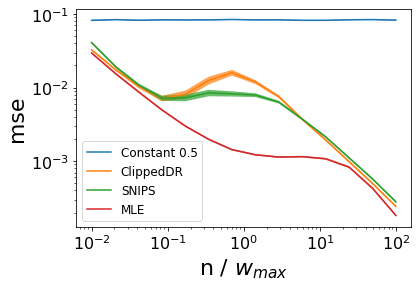

In [5]:
%matplotlib inline

class FlassPlot:
    @staticmethod
    def pic(x, y, label):
        import matplotlib.pyplot as plt
        
        plt.loglog(x, y, label=label)
        plt.legend()
        
    @staticmethod
    def forpaper():
        import matplotlib.pyplot as plt

        LEGEND_SIZE = 12
        SMALL_SIZE = 16
        MEDIUM_SIZE = 22
        BIGGER_SIZE = 24

        plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
        plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
        plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
        plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
        plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
        plt.rc('legend', fontsize=LEGEND_SIZE)    # legend fontsize
        plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
        
    @staticmethod
    def axeslabel(xlabel, ylabel):
        import matplotlib.pyplot as plt
        
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        
    @staticmethod
    def title(title):
        import matplotlib.pyplot as plt
        
        plt.title(title)
        
    @staticmethod
    def savefig(filename):
        import matplotlib.pyplot as plt
        
        plt.savefig(filename, bbox_inches='tight')
        
    @staticmethod
    def plt():
        import matplotlib.pyplot as plt
        
        return plt
  
import pickle
allres = pickle.load(open( "epsilongreedy_estimate_allres.p", "rb" ) )

renameit = { }
FlassPlot.forpaper()
for name, res in allres:
    x = [ x[0] for x in res ]
    y = [ x[1]['mse'] for x in res ]
    ylo = [ x[1]['mse'] - 1.96 * x[1]['msestd'] for x in res ]
    yhi = [ x[1]['mse'] + 1.96 * x[1]['msestd'] for x in res ]
    FlassPlot.plt().loglog([ x[0] for x in res ], [ x[1]['mse'] for x in res ], label=renameit.get(name, name))
    FlassPlot.plt().fill_between(x, ylo, yhi, alpha=0.7)
FlassPlot.plt().legend()

FlassPlot.axeslabel('n / $w_{max}$', 'mse')
FlassPlot.plt().savefig("epsilongreedy_mse.pdf", bbox_inches='tight')